In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
stop_words_es = nltk.corpus.stopwords.words('spanish')
# stop_words_pt = nltk.corpus.stopwords.words('portuguese')
from nltk.stem.snowball import SnowballStemmer
stem_es = SnowballStemmer('spanish')
# stem_pt = SnowballStemmer('portuguese')
from nltk.tokenize import sent_tokenize, word_tokenize
import csv
from tqdm import tqdm

In [91]:
### data source: https://chequeado.com/latamcoronavirusportugues/
df = pd.read_csv("./raw-data/Basededatos-Latamcoronavirus-inSpanish.csv",
                 warn_bad_lines=False,
           encoding = 'utf-8',error_bad_lines=False, sep=',',quoting=csv.QUOTE_MINIMAL)

In [92]:
import unicodedata
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [2]:
import stanza
# stanza.download('es') 
# stanza.download('pt') 

nlp_es = stanza.Pipeline(lang='es')
# nlp_pt = stanza.Pipeline(lang='pt')

2021-04-13 22:30:57 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-04-13 22:30:57 INFO: Use device: cpu
2021-04-13 22:30:57 INFO: Loading: tokenize
2021-04-13 22:30:57 INFO: Loading: mwt
2021-04-13 22:30:57 INFO: Loading: pos
2021-04-13 22:30:57 INFO: Loading: lemma
2021-04-13 22:30:58 INFO: Loading: depparse
2021-04-13 22:30:58 INFO: Loading: ner
2021-04-13 22:30:59 INFO: Done loading processors!


In [9]:
df.head()

,País,Título,Calificación,Descripción,Fecha del chequeo,Organización,Link al chequeo,Tipo de información,Formato de la desinformación,Tipo de nota,Link a la desinformación,Fecha detección desinformación,Origen,Persona,Actualizaciones,Circuló en otros países,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Argentina,Confirmado un caso de Coronavirus en Santiago ...,Falso,El Ministerio de Salud de la provincia afirmó ...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/no-no-se-...,Situación de un país,Imagen,Desinformación viral,https://drive.google.com/file/d/18MViCcWRoVVVg...,26/02/2020,Facebook,Desconocido,NaN,NaN,NaN,NaN,NaN,NaN
1,Argentina,Confirmado un caso de Coronavirus en Chaco.,Falso,El Ministerio de Salud de la provincia afirmó ...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-...,Situación de un país,Imagen,Desinformación viral,https://drive.google.com/file/d/1SJ2-A3WCr-vod...,NaN,Facebook,Desconocido,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,Un médico argentino descubrió y está aplicando...,Falso,La OMS informa que hasta el momento no existe ...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-...,Curas,"Imagen, Texto",Desinformación viral,https://drive.google.com/file/d/1FYpMz5CN3ZyyS...,NaN,"Redes sociales, Whatsapp",Desconocido,NaN,España,NaN,NaN,NaN,NaN
3,Argentina,"Presidente de Argentina, Alberto Fernández: “L...",Falso,La OMS no emitió ninguna recomendación sobre e...,12/3/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto...,Curas,Audio,Chequeo a figuras públicas,NaN,12/3/2020,Otros,Alberto Fernández (presidente de Argentina),NaN,"España, Hong Kong, Colombia",NaN,NaN,NaN,NaN
4,Argentina,"El presidente de Argentina, Alberto Fernández,...",Insostenible,Todavía no hay un consenso científico sobre el...,12/3/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto...,Características del virus,Audio,Chequeo a figuras públicas,NaN,12/3/2020,Otros,Alberto Fernández (presidente de Argentina),NaN,México,NaN,NaN,NaN,NaN


In [29]:
the_df = pd.DataFrame()
## clean/prepare text
for text, desc, outcome in tqdm(zip(df['Título'].tolist(), df['Descripción'].tolist(), df['Calificación'].tolist()), total=len(df['Título'].tolist()), position=0, leave=True):
    
    # remove accents
    text = strip_accents(text)
    desc = strip_accents(str(desc))
    
    # only keep words (remove other characters)
    tmp_read = re.sub('[^a-zA-Z]+', ' ', text).lower()
    tmp_read_dsc = re.sub('[^a-zA-Z]+', ' ', str(desc)).lower()
    
    #Tokenization and remove stop words
    tmp_read = [word for word in tmp_read.split() if word not in stop_words_es]
    tmp_read_dsc = [word for word in tmp_read_dsc.split() if word not in stop_words_es]
    # stemming
    tmp_read_stm = [stem_es.stem(word) for word in tmp_read]
    tmp_read_dsc_stm = [stem_es.stem(word) for word in tmp_read_dsc]
    # lemminization
    doc = nlp_es(" ".join(tmp_read))
    tmp_read_lem = [word.lemma for sent in doc.sentences for word in sent.words]
    doc_desc = nlp_es(" ".join(tmp_read))
    tmp_read_dsc_lem = [word.lemma for sent in doc_desc.sentences for word in sent.words]

    # rejoin textiews
    tmp_read = ' '.join(tmp_read)
    tmp_read_stm = ' '.join(tmp_read_stm)
    tmp_read_lem = ' '.join(tmp_read_lem)
    tmp_read_dsc = ' '.join(tmp_read_dsc)
    tmp_read_dsc_stm = ' '.join(tmp_read_dsc_stm)
    tmp_read_dsc_lem = ' '.join(tmp_read_dsc_lem)
    
    # add to new df
    tmp = pd.DataFrame([text], columns=['original title'])
    tmp['body_title'] = tmp_read
    tmp['body_stem_title'] = tmp_read_stm
    tmp['body_lem_title'] = tmp_read_lem
    
    tmp['body_desc'] = tmp_read_dsc
    tmp['body_stem_desc'] = tmp_read_dsc_stm
    tmp['body_lem_desc'] = tmp_read_dsc_lem
#     tmp['body_dict'] = dict_read
#     tmp['body_dict_stem'] = dict_read_stm
    tmp['classification'] = outcome

    the_df = the_df.append(tmp, ignore_index=True)

100%|██████████| 3869/3869 [27:31<00:00,  2.34it/s]


In [31]:
# readd country, language, and media
the_df = pd.concat([the_df, df[["País","Calificación","Origen",'Descripción','Fecha del chequeo']]], axis=1)
the_df = the_df.rename({"Descripción": "original description"}, axis=1)

In [32]:
# the_df.to_csv("./output-data/processed_text.csv", index=False)

In [40]:
def article_length(the_df, colname):
    '''count number of words in each speech'''
    l = pd.Series.tolist(the_df[[colname]])
    ct = 0
    count_per_speech = []
    for line in l:
        for i in line:
            if not isinstance(i, float):
                i = i.split()
                ct += 1
                count_per_speech.append(len(i))
            else:
                count_per_speech.append(0)
    the_df['total_'+colname] = count_per_speech
    return(the_df)

In [41]:
the_df = article_length(the_df, 'original title')
the_df = article_length(the_df, 'original description')

In [44]:
def summary_stats(the_df, colname):
    '''sent_length = num of sentences in speech
       num_word_unique = num of unique words in speech'''
    from nltk.tokenize import sent_tokenize, word_tokenize
    
    sent_len = []
    unique_len = []
    punctuations = '''!()-[]{}';:'"\,<>./?@#$%^&*_~``'''
    ct = 0
    for i in the_df[colname]:
        sents = sent_tokenize(str(i))
        tmp = word_tokenize(str(i))
        tmp_words = [str(i).lower() for i in tmp if i not in punctuations]
        
        tmp_unique = len(set(tmp))
        tmp_words = ' '.join(tmp_words)
        sent_len.append(len(sents))
        unique_len.append(tmp_unique)

    the_df['sent_length_'+colname] = sent_len
    the_df['num_word_unique_'+colname] = unique_len
    return(the_df)

In [45]:
the_df = summary_stats(the_df, 'original title')
the_df = summary_stats(the_df, 'original description')

### Sentiment Analysis

In [3]:
# https://pypi.org/project/sentiment-analysis-spanish/
from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [57]:
the_df['body_stem_title_sent'] = [sentiment.sentiment(i) for i in the_df.body_stem_title]
the_df['body_stem_desc_sent'] = [sentiment.sentiment(i) for i in the_df.body_stem_desc]

In [58]:
the_df['body_lem_title_sent'] = [sentiment.sentiment(i) for i in the_df.body_lem_title]
the_df['body_lem_desc_sent'] = [sentiment.sentiment(i) for i in the_df.body_lem_desc]

In [94]:
the_df['body_title_sent'] = [sentiment.sentiment(i) for i in the_df.body_title]
the_df['body_desc_sent'] = [sentiment.sentiment(i) for i in the_df.body_desc]

In [4]:
pd.read_csv('./output-data/processed_text2.csv')

,index,original title,body_title,body_stem_title,body_lem_title,body_desc,body_stem_desc,body_lem_desc,classification,País,...,sent_length_original description,num_word_unique_original description,body_stem_title_sent,body_stem_desc_sent,body_lem_title_sent,body_lem_desc_sent,count_ind,body_title_sent,body_desc_sent,Fecha del chequeo
0,0.0,Confirmado un caso de Coronavirus en Santiago ...,confirmado caso coronavirus santiago estero,confirm cas coronavirus santiag ester,confirmado caso coronaviru santiago estero,ministerio salud provincia afirmo trataba desi...,ministeri salud provinci afirm trat desinforma...,confirmado caso coronaviru santiago estero,Falso,Argentina,...,1.0,13.0,0.497892,0.497892,0.253474,0.253474,1.0,0.253474,0.497892,27/02/2020
1,1.0,Confirmado un caso de Coronavirus en Chaco.,confirmado caso coronavirus chaco,confirm cas coronavirus chac,confirmado caso coronaviru chaco,ministerio salud provincia afirmo trataba desi...,ministeri salud provinci afirm trat desinforma...,confirmado caso coronaviru chaco,Falso,Argentina,...,1.0,13.0,0.497892,0.497892,0.253474,0.253474,1.0,0.253474,0.497892,27/02/2020
2,2.0,Un medico argentino descubrio y esta aplicando...,medico argentino descubrio aplicando vacuna co...,medic argentin descubri aplic vacun coronaviru...,medico argentino descubrir aplicar vacuna coro...,oms informa momento existe vacuna medicamento ...,oms inform moment exist vacun medicament antiv...,medico argentino descubrir aplicar vacuna coro...,Falso,Argentina,...,1.0,19.0,0.497892,0.497892,0.497892,0.497892,2.0,0.497892,0.162545,27/02/2020
3,3.0,"Presidente de Argentina, Alberto Fernandez: La...",presidente argentina alberto fernandez oms rec...,president argentin albert fernandez oms recomi...,presidente argentino alberto fernandez oms rec...,oms emitio ninguna recomendacion consumo bebid...,oms emiti ningun recomendacion consum beb prev...,presidente argentino alberto fernandez oms rec...,Falso,Argentina,...,1.0,27.0,0.360368,0.492445,0.100524,0.100524,1.0,0.189717,0.003694,12/3/2020
4,4.0,"El presidente de Argentina, Alberto Fernandez,...",presidente argentina alberto fernandez dijo co...,president argentin albert fernandez dij corona...,presidente argentino alberto fernandez decir c...,todavia consenso cientifico impacto temperatur...,todavi consens cientif impact temperatur ambie...,presidente argentino alberto fernandez decir c...,Insostenible,Argentina,...,1.0,18.0,0.497892,0.497892,0.515415,0.515415,1.0,0.094376,0.640673,12/3/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18/03/2021
3865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22/03/2021
3866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17/03/2021
3867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22/03/2021


In [5]:
sentiment.sentiment('¿Qué sabemos sobre la circular que alerta sobre ladrones que se hacen pasar por personal sanitario que realiza pruebas de coronavirus para robar en las casas en Madrid?')

0.7645686111429933

In [96]:
the_df.head()

,index,original title,body_title,body_stem_title,body_lem_title,body_desc,body_stem_desc,body_lem_desc,classification,País,...,num_word_unique_original title,sent_length_original description,num_word_unique_original description,body_stem_title_sent,body_stem_desc_sent,body_lem_title_sent,body_lem_desc_sent,count_ind,body_title_sent,body_desc_sent
0,0,Confirmado un caso de Coronavirus en Santiago ...,confirmado caso coronavirus santiago estero,confirm cas coronavirus santiag ester,confirmado caso coronaviru santiago estero,ministerio salud provincia afirmo trataba desi...,ministeri salud provinci afirm trat desinforma...,confirmado caso coronaviru santiago estero,Falso,Argentina,...,9,1,13,0.497892,0.497892,0.253474,0.253474,1,0.253474,0.497892
1,1,Confirmado un caso de Coronavirus en Chaco.,confirmado caso coronavirus chaco,confirm cas coronavirus chac,confirmado caso coronaviru chaco,ministerio salud provincia afirmo trataba desi...,ministeri salud provinci afirm trat desinforma...,confirmado caso coronaviru chaco,Falso,Argentina,...,8,1,13,0.497892,0.497892,0.253474,0.253474,1,0.253474,0.497892
2,2,Un medico argentino descubrio y esta aplicando...,medico argentino descubrio aplicando vacuna co...,medic argentin descubri aplic vacun coronaviru...,medico argentino descubrir aplicar vacuna coro...,oms informa momento existe vacuna medicamento ...,oms inform moment exist vacun medicament antiv...,medico argentino descubrir aplicar vacuna coro...,Falso,Argentina,...,15,1,19,0.497892,0.497892,0.497892,0.497892,2,0.497892,0.162545
3,3,"Presidente de Argentina, Alberto Fernandez: La...",presidente argentina alberto fernandez oms rec...,president argentin albert fernandez oms recomi...,presidente argentino alberto fernandez oms rec...,oms emitio ninguna recomendacion consumo bebid...,oms emiti ningun recomendacion consum beb prev...,presidente argentino alberto fernandez oms rec...,Falso,Argentina,...,23,1,27,0.360368,0.492445,0.100524,0.100524,1,0.189717,0.003694
4,4,"El presidente de Argentina, Alberto Fernandez,...",presidente argentina alberto fernandez dijo co...,president argentin albert fernandez dij corona...,presidente argentino alberto fernandez decir c...,todavia consenso cientifico impacto temperatur...,todavi consens cientif impact temperatur ambie...,presidente argentino alberto fernandez decir c...,Insostenible,Argentina,...,19,1,18,0.497892,0.497892,0.515415,0.515415,1,0.094376,0.640673


In [98]:
## remove Brazil and Portuguel
the_df.País.unique()

array(['Argentina', 'Colombia', 'México', 'Perú', 'España', 'Venezuela',
       'Bolivia', 'Guatemala', 'Ecuador', 'Brasil', 'Costa Rica',
       'Paraguay', 'República Dominicana', 'Cuba', 'Nicaragua', 'Chile',
       'Uruguay', 'Portugal', ',Falso"', 'Serbia', 'Alemania', 'Francia',
       'Suiza', 'Estados Unidos'], dtype=object)

In [101]:
the_df = the_df[~the_df.País.isin(['Portugal', 'Brasil'])]

In [180]:
# the_df.to_csv("./output-data/processed_text2.csv", index=False)

[(0.0, 2300.0)]

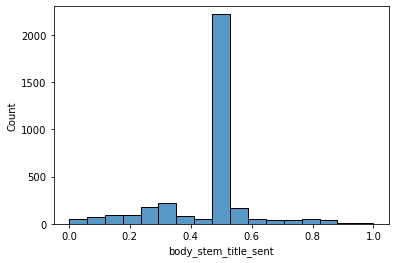

In [127]:
import seaborn as sns
sub = the_df[the_df.body_stem_title_sent!="-"]
g = sns.histplot(the_df, x="body_stem_title_sent",stat="count",bins="doane")
g.set(ylim=(0, 2300))

[(0.0, 2300.0)]

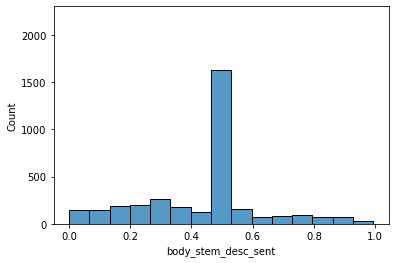

In [128]:
import seaborn as sns
sub = the_df[the_df.body_stem_desc_sent!="-"]
g = sns.histplot(sub, x="body_stem_desc_sent",stat="count", bins="doane")
g.set(ylim=(0, 2300))

In [ ]:
### having trouble downloading pyplot to get Portugeuse sentiment analysis
## https://polyglot.readthedocs.io/en/latest/Sentiment.html

### Article source count

In [130]:
the_df.columns

Index(['index', 'original title', 'body_title', 'body_stem_title',
       'body_lem_title', 'body_desc', 'body_stem_desc', 'body_lem_desc',
       'classification', 'País', 'Calificación', 'Origen',
       'original description', 'Fecha detección desinformación',
       'total_original title', 'total_original description',
       'sent_length_original title', 'num_word_unique_original title',
       'sent_length_original description',
       'num_word_unique_original description', 'body_stem_title_sent',
       'body_stem_desc_sent', 'body_lem_title_sent', 'body_lem_desc_sent',
       'count_ind', 'body_title_sent', 'body_desc_sent'],
      dtype='object')

In [131]:
source_per_article = []
for i, ind in zip(the_df.Origen, the_df.index):
    source_per_article.append(len(str(i).split(", ")))

In [132]:
the_df['count_ind'] = source_per_article

<ipython-input-132-e3ea16b85394>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_df['count_ind'] = source_per_article


In [133]:
source_unique = []
for source,i in zip(the_df['count_ind'], the_df['Origen']):
    if int(source)>1:
        source_unique.append(i.split(", "))
    else:
        source_unique.append([str(i)])
        
len(source_unique)

3490

In [134]:
flat_list = [item for sublist in source_unique for item in sublist]

In [135]:
len(flat_list)

4040

In [136]:
new_the_df = pd.DataFrame({col: np.repeat(the_df[col], the_df.count_ind) for col in the_df.columns})

In [137]:
new_the_df.shape

(4040, 27)

In [138]:
new_the_df['source'] = flat_list

In [139]:
new_the_df.source = [i.rstrip() for i in new_the_df.source]

In [140]:
new_the_df.source.unique()

array(['Facebook', 'Redes sociales', 'Whatsapp', 'Otros', 'Medios',
       'Twitter', 'Youtube', 'Email', 'nan', 'Instagram', 'Desconocido',
       '20/03/2020', 'Web oficial del Gobierno', '13/04/2020',
       'https://drive.google.com/open?id=1k2VXWgFPaHe1RzHv8DKtrTDFExuI8zRM',
       'SMS', 'Síntomas', 'Explicador',
       'Guillermo Moreno (candidato presidencial en República Dominicana por el partido Alianza País)',
       'Periodista salvadoreño Roberto Valencia', 'Sitios web',
       'https://drive.google.com/open?id=1WeDvawH06K_cGRZKMFBM96Zn2OEfmbCq',
       'Texto', 'Twittter', 'Video', 'YouTube',
       'https://maldita.es/app/uploads/2020/05/BULO-poema-1800.jpg',
       'Leonel Fernández (candidato presidencial de la Fuerza del Pueblo (FP) en República Dominicana)',
       '5/6/2020', 'Imagen', 'Desinformación viral',
       'https://maldita.es/app/uploads/2020/06/nasa-que-sabemos.jpg',
       'https://maldita.es/malditaciencia/2020/07/09/exosoma-james-hildreth-coronavirus/?

**Clean source names**

In [169]:
new_the_df.loc[new_the_df.source.isin(['SMS','Telegram','Zoom',
                                       'Pânico na TV','radio show','Texto','Explicador',
                                      'TikTok','Video', 'Síntomas','Prevención',
                                      "https://maldita.es/app/uploads/2020/09/FondoSanchezConfinamiento2.jpg",
                                      "Pinterest",'Imagen','Desinformación viral','Curas',
                                      'https://maldita.es/app/uploads/2020/12/photo5929119545614775399.jpg',
                                      "https://drive.google.com/open?id=1WeDvawH06K_cGRZKMFBM96Zn2OEfmbCq",
"https://chequeado.com/wp-content/uploads/2021/01/Tapa-Ecuador_F.png",
"https://www.animalpolitico.com/wp-content/uploads/2021/02/regalo.jpg",
'https://www.animalpolitico.com/wp-content/uploads/2021/01/FALSO_azitromicina-ivermectina-.jpg']), 
               "source"] = "Other (TV, Zoom, SMS, Radio, etc.)"

new_the_df.loc[new_the_df.source.isin(['Defensor do Povo do Peru', 'Ivan Arias (Ministro de Obras Públicas da Bolívia)',
                                       'Ismael Reyes (candidato à presidência pelo Partido Democrata Institucional na República Dominicana)', 
                                       'Jerônimo do Sertão (activist)', 'Leonel Fernández (candidato presidencial da Força do Povo (FP) na República Dominicana)', 
                                       'Cacau Menezes (journalist)', 'Perfil do Presidente Jair Bolsonaro', 'Cacau Menezes (jornalista)', 
                                       'Walter Gutiérrez', 'Desconocido', 'Periodista salvadoreño Roberto Valencia',
                                      'Leonel Fernández (candidato presidencial de la Fuerza del Pueblo (FP) en República Dominicana)',
                                      'Guillermo Moreno (candidato presidencial en República Dominicana por el partido Alianza País)',
                                      'Delcy Rodríguez (vicepresidenta de Venezuela)']), "source"] = "Person"

new_the_df.loc[new_the_df.source.isin(['Veículos de comunicação.', 'Veículos de comunicaçãos', 
                                       'veículo de comunicação', "Veículo de comunicação",
                                       'Redes sociais Veículos de comunicação', 
                                       'Redes sociais e Vweículos de comunicação']), 
               "source"] = "Veículos de comunicação"

new_the_df.loc[new_the_df.source.isin(["meio de comunicação", "Meios de comunicação","Meio de Comunicação",
                                      "Meios de Comunicação"]), "source"] = "Meio de comunicação"

new_the_df.loc[new_the_df.source=="Facebok", "source"] = "Facebook"
new_the_df.loc[new_the_df.source=="Email", "source"] = "E-mail"
new_the_df.loc[new_the_df.source=="Twittter", "source"] = "Twitter"
new_the_df.loc[new_the_df.source=="YouTube", "source"] = "Youtube"
new_the_df.loc[new_the_df.source=="Desconhecido", "source"] = "nan"

new_the_df.loc[new_the_df.source.isin(['Annonymous Incision (website)', 'Stylo Urbano (website)', 
                                       'WhatsApp e Redes Sociais', 'Blog', 'Terça Livre (website)', 
                                       'Terra Brasil Online (website)', 'Terra Brasil Notícias (site)', 
                                       'sites', 'Sociedade Política (website)', '76GoGoNews (website)', 
                                       'Brasil 61 (website)', 'Brasil Sem Medo (website)', 
                                       'Contrafatos (website)', 'Diário do Brasil (website)', 
                                       'Diário do Poder (website)', 'Imprensa Brasil (website)', 
                                       'Mídia sem Máscara (website)', 'Portal oficial do Governo', 
                                       'Portal Oficial do Governo','Sites da internet', 
                                       'Meio de Comunicação (site)', 'Web oficial del Gobierno',
                                      'Sitios web', 'Página web', 'Website',
                                      "https://maldita.es/app/uploads/2020/06/nasa-que-sabemos.jpg",
"https://maldita.es/app/uploads/2020/05/BULO-poema-1800.jpg",
"https://maldita.es/malditaciencia/2020/07/09/exosoma-james-hildreth-coronavirus/?fbclid=IwAR0ez9kz8xmhT1HWCUtSNa2tg9Fut-yn36_hIM2pWFnwV-vgWEHaGRwAjcU"]), "source"] = "Website"

new_the_df.loc[new_the_df.source.isin(["WhatsApp","WhasApp",'WhasApp', 'WhtatsApp', 
                                       'WhatsApp e Redes Sociais', 'Whatsap','https://drive.google.com/open?id=1k2VXWgFPaHe1RzHv8DKtrTDFExuI8zRM']), "source"] = "Whatsapp"

new_the_df.loc[new_the_df.source.isin(["Redes sociais e WhatsApp", "Redes Sociais sociales",
                                      "Redes Sociais", "RedesSociais", "Redes Socais"]), "source"] = "Redes sociais"

new_the_df.loc[new_the_df.source.isin(["20/07/2020", "20/03/2020", "5/6/2020", "13/04/2020"]), "source"] = np.nan

In [143]:
# the_df.reset_index(inplace=True)

In [ ]:
# website
"https://maldita.es/app/uploads/2020/06/nasa-que-sabemos.jpg",
"https://maldita.es/app/uploads/2020/05/BULO-poema-1800.jpg",
"https://maldita.es/malditaciencia/2020/07/09/exosoma-james-hildreth-coronavirus/?fbclid=IwAR0ez9kz8xmhT1HWCUtSNa2tg9Fut-yn36_hIM2pWFnwV-vgWEHaGRwAjcU"

# whatsapp
"ttps://drive.google.com/open?id=1k2VXWgFPaHe1RzHv8DKtrTDFExuI8zRM",

# image
"https://drive.google.com/open?id=1WeDvawH06K_cGRZKMFBM96Zn2OEfmbCq",
"https://chequeado.com/wp-content/uploads/2021/01/Tapa-Ecuador_F.png"
"https://www.animalpolitico.com/wp-content/uploads/2021/02/regalo.jpg"
'https://www.animalpolitico.com/wp-content/uploads/2021/01/FALSO_azitromicina-ivermectina-.jpg'

In [175]:
new_the_df.groupby("source").count().sort_values("count_ind",ascending=False)['count_ind']

source
Facebook                              1082
nan                                    834
Whatsapp                               727
Redes sociales                         499
Twitter                                327
Medios                                 265
Otros                                  119
Youtube                                 84
Other (TV, Zoom, SMS, Radio, etc.)      49
Instagram                               23
E-mail                                  10
Person                                  10
Website                                  7
Name: count_ind, dtype: int64

In [176]:
new_the_df.to_csv("./output-data/source_count.csv", index=False)

### Topic Modeling 

In [181]:
# I added a bigram column to this dataframe earlier
bigram_lem = pd.read_csv("./output-data/df_bigrams_lem.csv")

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [182]:
# wordlist = [i.split() for i in the_df.body_lem_title]

In [183]:
wordlist2 = [str(i).split() for i in bigram_lem.bigram]
wordlist2

[['comerciante', 'hueco'],
 ['hueco', 'internado'],
 ['internado', 'hospital'],
 ['hospital', 'medellin'],
 ['medellin', 'sintoma'],
 ['sintoma', 'coronavirus'],
 ['muerte', 'coronaviru'],
 ['coronaviru', 'wuhon'],
 ['video', 'mercado'],
 ['mercado', 'empezar'],
 ['empezar', 'coronavirus'],
 ['coronavirus', 'wuhon'],
 ['coronavirus', 'llegado'],
 ['llegado', 'cucuta'],
 ['nombre', 'creador'],
 ['creador', 'coronavirus'],
 ['coronavirus', 'raul'],
 ['raul', 'rodolfo'],
 ['rodolfo', 'abhduz'],
 ['abhduz', 'khan'],
 ['khan', 'supuestamente'],
 ['supuestamente', 'ingeniero'],
 ['ingeniero', 'bioquimico'],
 ['bioquimico', 'karmalah'],
 ['karmalah', 'laboratorie'],
 ['clorito', 'sodio'],
 ['sodio', 'cura'],
 ['cura', 'coronaviru'],
 ['comercio', 'veracruz'],
 ['veracruz', 'cerrar'],
 ['cerrar', 'coronavirus'],
 ['mexico', 'pleno'],
 ['pleno', 'pico'],
 ['pico', 'virus'],
 ['virus', 'dos'],
 ['dos', 'semana'],
 ['semana', 'ir'],
 ['ir', 'aparecer'],
 ['aparecer', 'infectado'],
 ['infectado', 

In [187]:
from gensim import corpora
import gensim
dictionary = corpora.Dictionary(wordlist2)
corpus = [dictionary.doc2bow(text) for text in wordlist2]

In [188]:
NUM_TOPICS = 6
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, 
                                           passes=25,
                                          random_state=99)

In [189]:
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.147*"covid" + 0.034*"coronaviru" + 0.026*"vacuna" + 0.017*"caso" + 0.015*"hospital" + 0.015*"dioxido" + 0.014*"positivo" + 0.013*"cloro"')
(1, '0.035*"persona" + 0.033*"nan" + 0.027*"mostrar" + 0.025*"imagen" + 0.019*"gobierno" + 0.016*"muerte" + 0.016*"pcr" + 0.016*"morir"')
(2, '0.090*"coronavirus" + 0.051*"decir" + 0.038*"nuevo" + 0.023*"cura" + 0.022*"ser" + 0.018*"uso" + 0.017*"ciudad" + 0.015*"vacuna"')
(3, '0.039*"poder" + 0.030*"mas" + 0.025*"afirmar" + 0.025*"prueba" + 0.023*"hacer" + 0.023*"él" + 0.022*"pais" + 0.020*"salud"')
(4, '0.036*"argentino" + 0.036*"medico" + 0.026*"pandemia" + 0.019*"paciente" + 0.017*"virus" + 0.011*"cadena" + 0.011*"evitar" + 0.010*"llevar"')
(5, '0.059*"asegurar" + 0.045*"vacuna" + 0.033*"video" + 0.023*"mascarilla" + 0.017*"presidente" + 0.014*"si" + 0.013*"supuesto" + 0.013*"publicacion"')


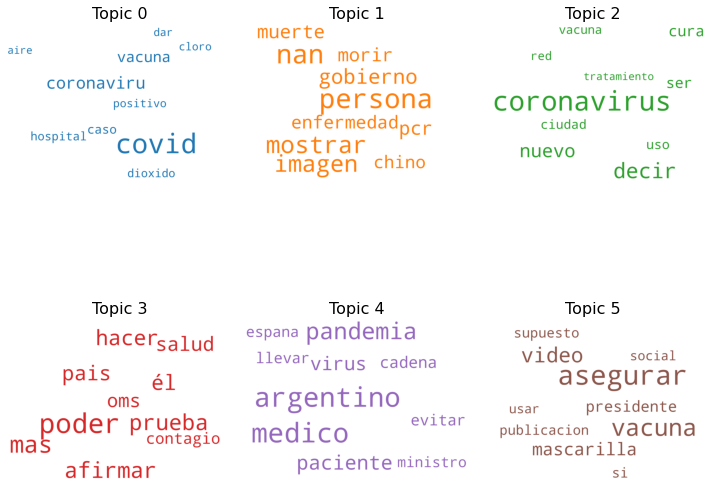

In [191]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words_es,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()